## Klasifikasi kemiripan teks
Pada kali ini kita akan menganalisis sebuah dataset yang bersifat teks. Quora menyediakan dataset yang berisi tentang pertanyaan 1 dengan pertanyaan yang lainnya, kemudian ada label yang berisi tentang skor kemiripan pada pertanyaan tersebut. Quora ingin seseorang tidak perlu menanyakan pertanyaan yang sama jika pertanyaan tersebut sudah pernah diposting oleh orang lain.<br>

Use case ini bisa diaplikasikan untuk kelancaran customer service di sebuah perusahaan dalam menjawab pertanyaan para customer. Diharapkan jika customer service mengetik pertanyaan yang diajukan oleh customer, maka dengan teknik machine learning customer service akan mendapatkan respons apakah pertanyaan ini sudah pernah diajukan, beserta respons terbaik untuk menjawab pertanyaan yang diajukan tersebut

Kita akan melakukan teknik klasifikasi pada dataset Quora ini, untuk mengetahui kemiripan pertanyaan yang diajukan.
Dalam proses yang sudah dilakukan, akan didapat hasil akurasi sebesar 84.8% dengan algoritma Logistic Regression, dan akurasi 85.99% dengan algoritma xgboost.




In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from subprocess import check_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import os
import gc
from collections import defaultdict
import seaborn as sns
%matplotlib inline
import time
pal = sns.color_palette()


import matplotlib.pyplot as plt

### Data Quora Pairs Dataset diambil dari Kaggle
### Dalam notebook ini saya mencoba menganalisis dan membuat model yang bisa membuat prediction apakah ada duplicate question atau tidak

In [2]:
df = pd.read_csv('questions.csv').dropna().reset_index(drop='index') #drop missing values

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [21]:
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Duplicate pairs: 36.92%


# Text Analysis

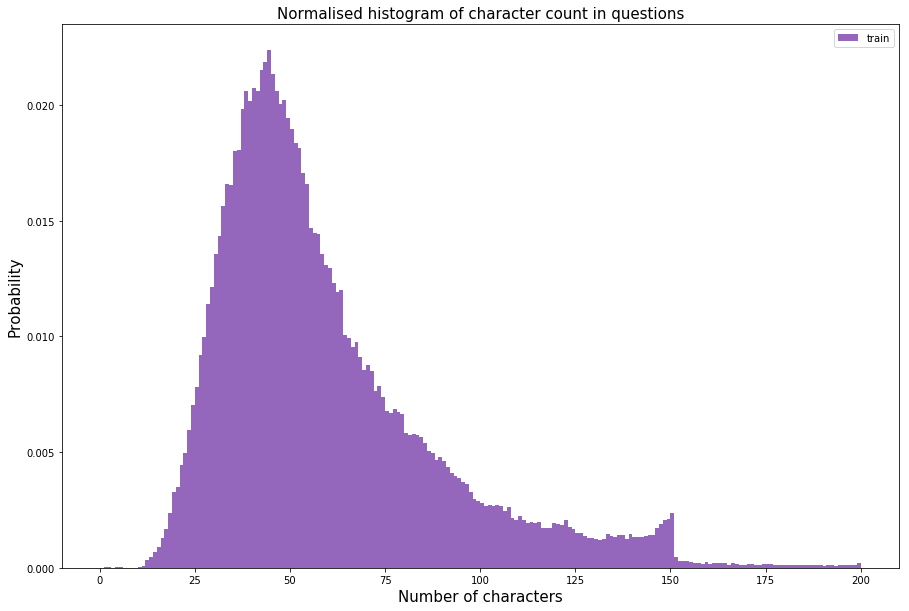

mean-train 59.82 std-train 31.96  max-train 1169.00 


In [5]:
qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)


dist_qs = qs.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_qs, bins=200, range=[0, 200], color=pal[4],density=True,  label='train')

plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()
print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_qs.mean(), 
                          dist_qs.std(),  dist_qs.max()))


mean-train 11.06 std-train 5.89  max-train 237.00 


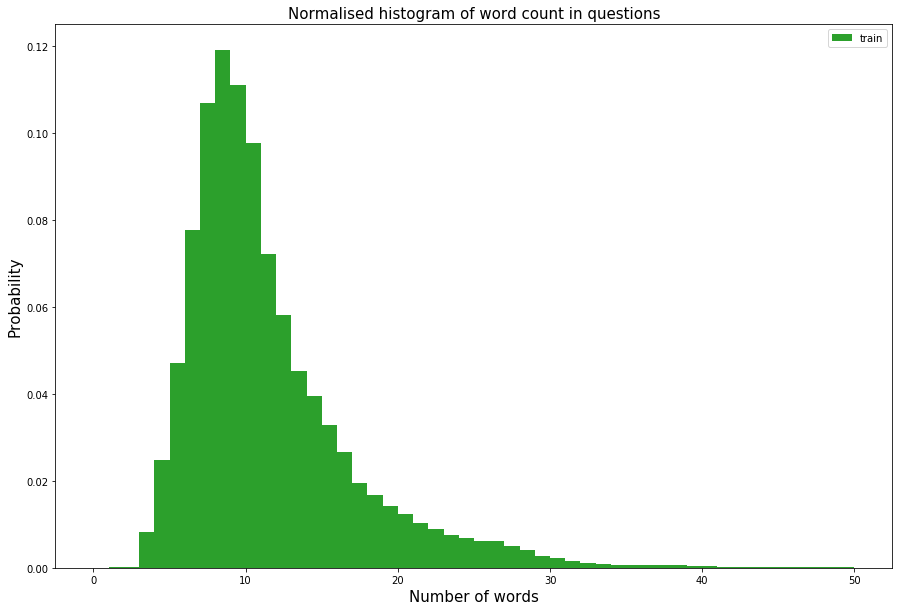

In [6]:
dist_qs = qs.apply(lambda x: len(x.split(' ')))


plt.figure(figsize=(15, 10))
plt.hist(dist_qs, bins=50, range=[0, 50], color=pal[2], density=True, label='train')

plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_qs.mean(), 
                          dist_qs.std(), dist_qs.max()))

Dari distribusi "number of character' kita bisa lihat bahwa dari pertanyaan yg terdapat dari dataset kebanyakan mempunyai 40-70 karakter. Kemudian distribusinya menurun drastis saat di 150++ karakter, yang kemudian disini saya berasumsi  terdapat limit karakter untuk membuat pertanyaan, mungkin terdapat limit 160 karakter

Dari distribusi "number of words", agak similiar dengan distribusi karakter, dengan kebanyakan pertanyaan mempunyai 9-11 kata.

Berikut diimplementasikan WordCloud untuk melihat kata yg sangat common di dataset

(-0.5, 1439.5, 1079.5, -0.5)

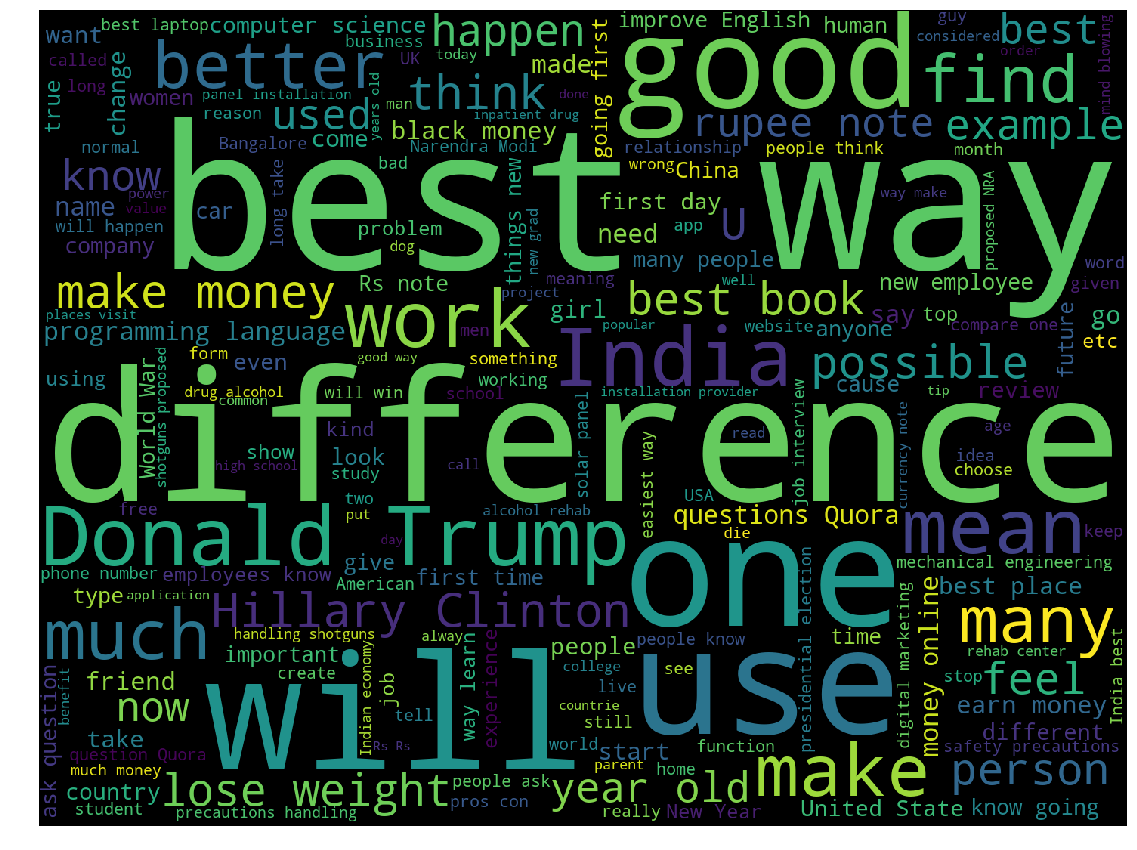

In [8]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Implementasi Cosine Similiarity

In [9]:
corpus =pd.concat([df.question1,df.question2])

# Membuat vektor TF-IDF terlebih dahulu yang nantinya akan digunakan untuk menghitung Cosine-Similiarity dari 2 questions yang
# akan dibandingkan

tfidf = TfidfVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        lowercase = True, norm = 'l1')


cv = tfidf.fit(corpus)

duplicates = df.loc[df.is_duplicate>=0,['question1','question2']]


In [10]:
duplicates.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [12]:
#procedure untuk menghitung lamanya waktu yang dijalankan
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


start_time = timer(None) # waktu dimulai
#menghitung nilai cosine_similiarity untuk tiap-tiap row
duplicates_csim = []

for j in range(duplicates.shape[0]):
    
    a = cv.transform([duplicates.iloc[j].question1])
    b = cv.transform([duplicates.iloc[j].question2])
    
    duplicates_csim.append( cosine_similarity(a,b).ravel()[0])
    
timer(start_time) #waktu selesai


 Time taken: 0 hours 16 minutes and 9.9 seconds.


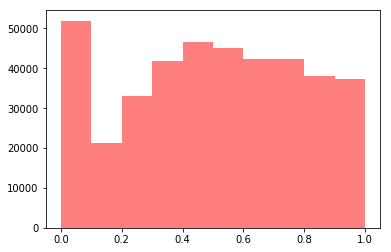

In [13]:
plt.hist(duplicates_csim, alpha = 0.5, color = 'r',  bins = np.linspace(0,1,11))
plt.show()

In [14]:
df = df.assign(cossim_score=duplicates_csim)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.981793
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.791946
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.276089
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.243623


# Apply Cosine_similiarity for modelling

In [15]:
dfcos = {'cossim_score': df.cossim_score, 'is_duplicate': df.is_duplicate}
dfcoss = pd.DataFrame(data=dfcos)

In [16]:
dfcoss.groupby(['is_duplicate']).mean()

,cossim_score
is_duplicate,
0,0.415868
1,0.662452


Dari data diatas dapat disimpulkan bahwa cosine similiarity mempunyai pengaruh pada duplicate atau tidaknya 2 pertanyaan yang akan dibandingkan, dengan 0(tidak duplicate) mempunyai mean cossine_similiarity score sebesar 0.415868, sedangkan duplicate mempunyai score sebesar 0.662452

In [17]:


# Importing the dataset

X = dfcoss.iloc[:, [0]].values
y = dfcoss.iloc[:, 1].values

In [18]:
#Applying SVC 
start_time = timer(None) 
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Apply SVC ke training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting Test set
y_pred = classifier.predict(X_test)

timer(start_time) 


 Time taken: 0 hours 28 minutes and 52.05 seconds.


In [19]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy score is {}%.".format(accuracy.round(2)))

print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy score is 66.27%.
[[48990 14731]
 [19369 17998]]

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.77      0.74     63721
          1       0.55      0.48      0.51     37367

avg / total       0.66      0.66      0.66    101088



Dari kesimpulan diatas, Akurasi yang didapat setelah implementasi Cosine Similiarity, yaitu 66.27%, meningkat 4% dari baseline(is_duplicate == 0). Menurut saya Cosine Similiarity untuk dataset ini belum cocok untuk membuat model yang paten, karena akurasi yang didapat dari model hanya 66.27%. Namun cocok untuk menjadi salah satu independent variable dari Feature Engineering.

Kita lihat pada cell 18, waktu yang dibutuhkan SVC untuk fit dataset adalah 29 menit, karena jumlah data yang saya punya adalah 400.000 row.
pada nantinya dalam membuat Feature Engineering, saya akan menggunakan subsample hanya untuk menemukan best parameter, menggunakan Grid Search, supaya waktu lebih efisien. Kemudian setelah menemukan best parameter, akan saya aplikasikan parameter tersebut ke Dataset yang asli

# Applying Other Feature Engineering

# Magic Feature
Feature ini berdasarkan dari frekuensi dari sebuah pertanyaan dari seluruh dataset, 
Setelah itu akan dihubungkan  question1 dan question2 untuk mengetahui nilai intersect dari kedua variable tersebut


In [22]:

que = {'question1': df.question1, 'question2': df.question2}
ques = pd.DataFrame(data=que)

In [23]:
ques.isnull().sum()

question1    0
question2    0
dtype: int64

In [24]:
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [25]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [26]:
ques['q1_q2_intersect'] = ques.apply(q1_q2_intersect, axis=1, raw=False)

In [27]:
ques.shape

(404351, 3)

In [28]:
df = df.assign(q1_q2_intersect=ques.q1_q2_intersect)
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score,q1_q2_intersect
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,0.692087,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1,0.633466,10
404348,404348,789796,789797,What is one coin?,What's this coin?,0,1.000000,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,0.000000,0
404350,404350,789800,789801,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0,1.000000,0


# Word Share Feature. 
Feature ini didapat dari benchmark model. nilainya  didapat dengan menemukan sebuah kecocokan yang didapat dari question1 dan question2

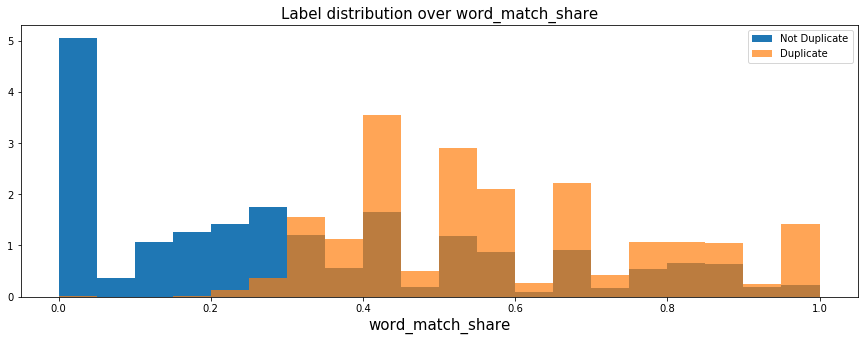

In [29]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R




plt.figure(figsize=(15, 5))
train_word_match = df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(train_word_match[df['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.show()

In [30]:
# Function to report the quality of the model
def performance_report(value, score_list):
    # the value (0-1) is the cosine similarity score to determine if a pair of questions
    # have the same meaning or not.
    scores = []
    for score in score_list:
        if score >= value:
            scores.append(1)
        else:
            scores.append(0)

    accuracy = accuracy_score(df.is_duplicate, scores) * 100
    print("Accuracy score is {}%.".format(accuracy.round(2)))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(df.is_duplicate, scores))
    print()
    print("Classification Report:")
    print(classification_report(df.is_duplicate, scores))

In [31]:
performance_report(0.34, train_word_match)

Accuracy score is 71.34%.

Confusion Matrix:
[[154369 100676]
 [ 15230 134076]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.61      0.73    255045
          1       0.57      0.90      0.70    149306

avg / total       0.79      0.71      0.72    404351



In [33]:
#memasukkan word_match menjadi sebuah fitur
df = df.assign(word_match=train_word_match)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score,q1_q2_intersect,word_match
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.981793,0,0.727273
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.791946,0,0.307692
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.276089,0,0.363636
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.243623,0,0.000000


# Common Sense Feature

Dari sebuah analisis saya, saya berasumsi bahwa duplikat atau tidaknya sebuah pertanyaan tergantung dari perbedaan jumlah karakter, dan perbedaan jumlah kata. Oleh karena itu saya akan masukkan menjadi salah satu feature engineering

In [35]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))



df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score,q1_q2_intersect,word_match,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.981793,0,0.727273,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.791946,0,0.307692,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.276089,0,0.363636,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0,0.000000,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.243623,0,0.000000,76,39,13,7


In [36]:
df['diff_char'] = abs(df['q1len'] - df['q2len']) 
df['diff_word'] = abs(df['q1_n_words'] - df['q2_n_words'])

In [37]:
del df['q1len']
del df['q2len']
del df['q1_n_words']
del df['q2_n_words']

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score,q1_q2_intersect,word_match,diff_char,diff_word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.981793,0,0.727273,9,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.791946,0,0.307692,37,5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.276089,0,0.363636,14,4
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0,0.000000,15,2
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.243623,0,0.000000,37,6


# Menentukan Best Parameter   dengan MinMaxScaller

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df[['cossim_score', 'q1_q2_intersect', 'word_match', 'diff_char', 'diff_word']])

X = scaler.transform(df[['cossim_score', 'q1_q2_intersect', 'word_match' , 'diff_char', 'diff_word']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270915, 5), (133436, 5), (270915,), (133436,))

In [40]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0, 10, 100],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 0.001, 1.0, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [42]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

10. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l1'}
9. Mean validation neg log loss: -0.690 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
7. Mean validation neg log loss: -0.460 (std: 0.001) - {'C': 0.001, 'penalty': 'l1'}
8. Mean validation neg log loss: -0.523 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
4. Mean validation neg log loss: -0.343 (std: 0.002) - {'C': 1.0, 'penalty': 'l1'}
6. Mean validation neg log loss: -0.351 (std: 0.002) - {'C': 1.0, 'penalty': 'l2'}
2. Mean validation neg log loss: -0.343 (std: 0.002) - {'C': 10, 'penalty': 'l1'}
5. Mean validation neg log loss: -0.343 (std: 0.002) - {'C': 10, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.343 (std: 0.002) - {'C': 100, 'penalty': 'l1'}
3. Mean validation neg log loss: -0.343 (std: 0.002) - {'C': 100, 'penalty': 'l2'}


In [43]:
#Menentukan Best Parameter
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 100, 'penalty': 'l1'}
[[  2.12439527 115.188828     2.20581231  -7.73899811   7.70798995]]


C: 1e-06, parameters [[-0.00137151  0.00386214  0.00300972 -0.00127124 -0.00112286]] and intercept [-0.03316908]
C: 0.0001, parameters [[ 0.4851238   0.4103001   0.70753674 -0.06204941 -0.05434743]] and intercept [-0.94667485]
C: 1.0, parameters [[ 1.99739881 81.50347303  2.22625653 -3.10041526  2.02584816]] and intercept [-3.473686]
C: 10, parameters [[  2.10548146 109.2704423    2.20637701  -6.47135148   6.23360573]] and intercept [-3.63714385]
C: 100, parameters [[  2.12365126 114.52938865   2.20552534  -7.54577258   7.50687042]] and intercept [-3.66518601]


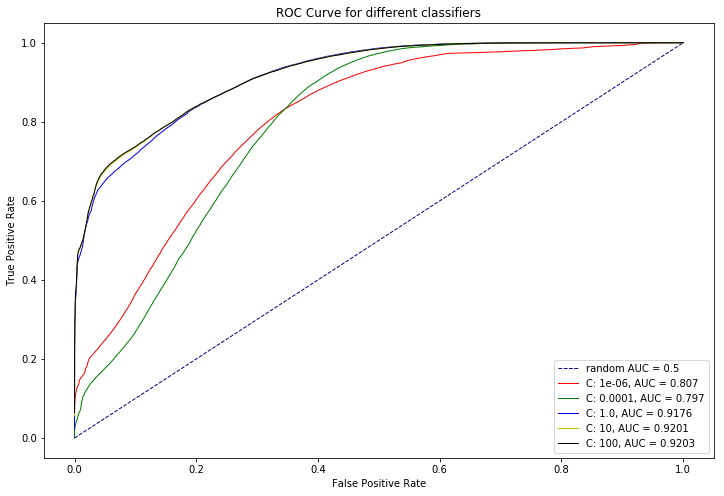

In [44]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0, 10, 100]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

Text(0,0.5,'Precision')

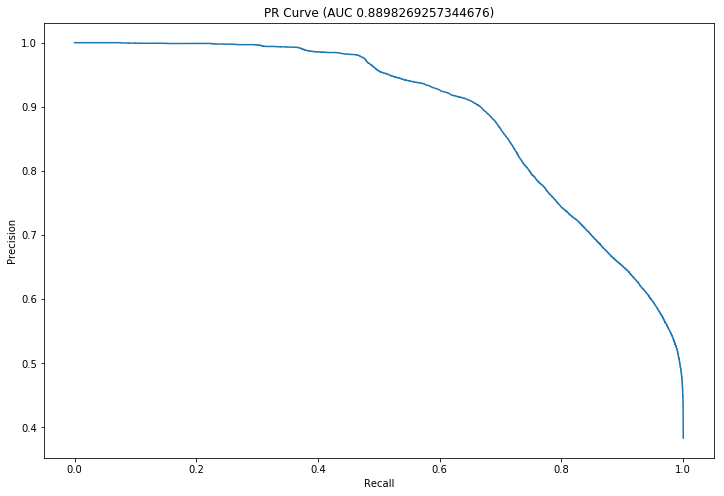

In [45]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

In [46]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cossim_score,q1_q2_intersect,word_match,diff_char,diff_word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.981793,0,0.727273,9,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.791946,0,0.307692,37,5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.276089,0,0.363636,14,4
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0,0.000000,15,2
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.243623,0,0.000000,37,6


# Start Modelling  with best parameter from MinMaxScaler

In [47]:
X = df.iloc[:, [6, 7, 8, 9, 10]].values
y = df.iloc[:, 5].values


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Fitting LogisticRegression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C = 100, penalty = "l1")
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


In [52]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy score is {}%.".format(accuracy.round(2)))

print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy score is 84.8%.
[[59499  4222]
 [11145 26222]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.93      0.89     63721
          1       0.86      0.70      0.77     37367

avg / total       0.85      0.85      0.84    101088



In [53]:
roc_auc_score(y_test, y_pred)

0.8177422936195814

#  Standard XGBoost (no tuning and gridsearch)

In [55]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [56]:
y_pred = classifier.predict(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy score is {}%.".format(accuracy.round(2)))

print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy score is 85.99%.
[[60143  3578]
 [10585 26782]]

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.94      0.89     63721
          1       0.88      0.72      0.79     37367

avg / total       0.86      0.86      0.86    101088



In [59]:
roc_auc_score(y_test, y_pred)

0.8302888154591057

## Kesimpulan: 

Feature Engineering Cosine Similiarity tidak terlalu berpengaruh terhadap modelling. Agar bisa mempunyai model yang berkualitas, kita harus membuat fitur-fitur baru melalui Feature Engineering. Pembuatan fitur ini bisa kita peroleh jika kita mengetahui domain knowledge terhadap dataset yang kita miliki. Selain itu Model yang berkualitas juga dapat kita peroleh jika kita melakukan Data Processing dengan baik.
